# NN design

Define and test some NN architectures and data vars. Train the models with the limited 21 day period of local data.

In [1]:
# 
from sklearn.model_selection import train_test_split
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import sys

sys.path.append("../")
from src.processing import windsat_datacube, create_landmask


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


<xarray.Dataset> Size: 4GB
Dimensions:         (day_number: 21, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables: (12/14)
    longitude       (day_number, longitude_grid, latitude_grid) float32 87MB dask.array<chunksize=(1, 1440, 720), meta=np.ndarray>
    latitude        (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    node            (day_number, swath_sector, latitude_grid, longitude_grid) float64 348MB dask.array<chunksize=(1, 2, 720, 1440), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band, latitude_grid, longitude_grid) float32 174MB dask.array<chunksize=(1, 2, 720, 1440), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band, latitude_grid, longitude_grid) float32 174MB dask.array<chunksize=(1, 2, 720, 1440), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band, latitude_grid, longitude_grid) float32 174MB dask.array<chunksize=(1, 2, 720, 1440), meta=np.ndarray>
    ...              ...
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 697MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) float64 348MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    landmask        (latitude_grid, longitude_grid) float64 8MB 0.0 0.0 ... nan
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

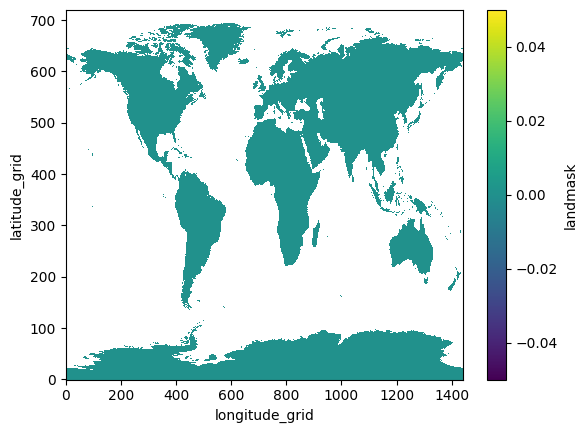

In [2]:
# Load the data in the folder
folder_path = "../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path=folder_path)
# Add the landmask and filter the dataset with only the land pixels

landmask = create_landmask(lat=ds.lat.values, lon=ds.lon.values)
ds["landmask"] = (("latitude_grid","longitude_grid"), landmask.values)

ds.landmask.attrs = {
    "Description": "Landmask object from regionmask, 0 for Land pixels, NaN for ocean"
}
ds.landmask.plot()

# Filter the ocean pixels
ds=ds.where(ds.landmask == 0)
ds

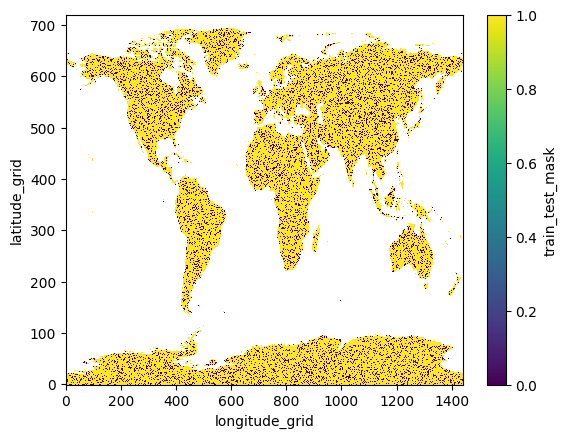

In [3]:
# Create the train-test mask
#TODO: Maybe worthit to wrap this into a function? 
land_indeces = np.argwhere(ds.landmask.values == 0)
train_indeces , test_indeces = train_test_split(land_indeces, test_size=0.2, random_state=13)
train_test_mask = np.copy(landmask)
train_test_mask[train_indeces[:,0], train_indeces[:,1]] = 1

ds["train_test_mask"] = (("latitude_grid", "longitude_grid"), train_test_mask)
ds.train_test_mask.attrs = {
    "Desccirption": "Random mask for train test split based on latitude and longitude (same for all days). Nan for Ocean, 0 for test, 1 for train"
}
ds.train_test_mask.plot()

In [4]:
# Separate the datastet( kind of redundant but is clearer for the user)
trainds = ds.where(ds.train_test_mask == 1)
testds = ds.where(ds.train_test_mask == 0)

# 2017 paper on nn architecture
""" 

Multilayer perceptrons are used to implement each neural network. The input layer has as many nodes as
the number of frequency channels and associated emissivities used for the inversion. It is followed by a hidden layer of 10 nodes, and the output layer with one node for the retrieved Ts. For the training, 105 cases
are randomly selected from the Tbs-Ts database. The initial weights of the neural network are randomly initialized by the Nguyen-Widrow algorithm [Nguyen and Widrow, 1990], and the final weights are assigned by
a Marquardt-Levenberg backpropagation algorithm [Hagan and Menhaj, 1994]. To prevent overfitting to the
training data set, a cross-validation technique is used to monitor the evolution of the training error function

"""

For now I will not use emissivities, but I could (TELSEM atlas)

Instead of channels, we would train on tbtoa, lat, lon and day_num. Possibly adding quality_flags, but they are categorical, we need to be carefull whith those.

ALSO: we have 2 frequencies x 2 polarizations

We need to separate the swath sectors in the predictions, for now we separate into two models, one for each pass (hour)




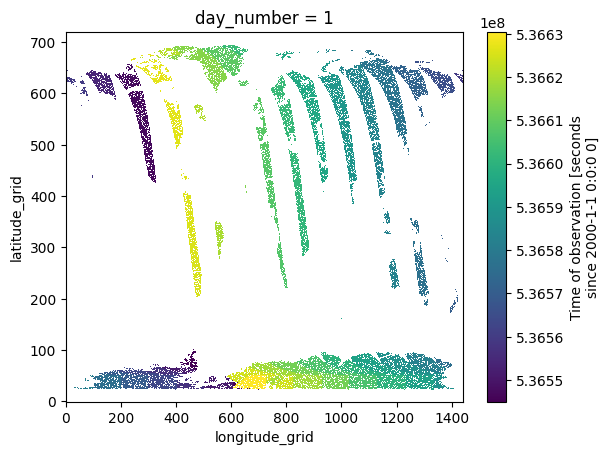

In [20]:
trainds.time.sel(day_number = 1, frequency_band= 1, swath_sector= 0).plot()

# TIME
It would be nice to add the time as a varialbe to predict. According to remss.com, all dates and times are Coordinates Universal Time (UTC). We should compute the local time for every pixel instead. Althoug it might not be necessary, since the network will also get latitude and longitude as inputs, so it might be able learn how to mix the three variables.

QUOTE. [https://www.remss.com/missions/windsat/](https://www.remss.com/missions/windsat/)

    ´We produce WindSat Daily and Time-Averaged (3-day, weekly and monthly) binary data files.  The files contain no headers or metadata and are a simple set of single-byte arrays as described below.  Since the data are stored as single bytes, no byte-swapping when transfering between machines is necessary.

    Gridded data files are organized according to observation date. All dates and times are Coordinated Universal Time (UTC), also known as Greenwich Mean Time (GMT), Zulu Time (Z), Universal Time (UT), and World Time.  Data products include daily and time averaged measurements as follows:

    Daily  	orbital data mapped to 0.25 degree grid 
    divided into 2 sets of maps based on ascending and descending passes 
    when adjacent passes overlap at high latitudes and daily "seam", earlier data is chosen. (See note below)
    3-Day  	average of 3 days ending on and including file date
    Weekly  	average of 7 days ending on and including the Saturday file date
    Monthly  	average of all data within the calendar month´

In any case, turning the values to seconds since the start of the day should reduce the order of magnitude, which could improve training.

## Notes:

We have a size 4 array as time for a single pixel, 2frequency_bands x 2swawths  (For some reason diferent frequencies also have diferent times ?? )

In [66]:
# given a point in the training data, extract the characteristics vector

xv = trainds.isel(
    {
        "latitude_grid": 300,
        "longitude_grid": 800
    }
)
variables = [
    "longitude",
    "latitude",
    "time",
    "quality_flag",
    "tbtoa"
]
xv = xv[variables]
xv

<xarray.Dataset> Size: 2kB
Dimensions:       (day_number: 21, frequency_band: 2, swath_sector: 2,
                   polarization: 2)
Coordinates:
    lat           float32 4B dask.array<chunksize=(), meta=np.ndarray>
    lon           float32 4B dask.array<chunksize=(), meta=np.ndarray>
  * day_number    (day_number) int32 84B 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 21
Dimensions without coordinates: frequency_band, swath_sector, polarization
Data variables:
    longitude     (day_number) float32 84B dask.array<chunksize=(1,), meta=np.ndarray>
    latitude      (day_number) float32 84B dask.array<chunksize=(1,), meta=np.ndarray>
    time          (day_number, frequency_band, swath_sector) float64 672B dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    quality_flag  (day_number, swath_sector) float64 336B dask.array<chunksize=(1, 1), meta=np.ndarray>
    tbtoa         (day_number, polarization, frequency_band, swath_sector) float32 672B dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

For every slice we have day_number(total) saples



In [100]:
# Separate every dimention into it own numeric value

for day in xv.day_number.values:
    # TODO: this is unefficient, select the full array and then separate the components (for time and tbtoa)

    # time of observation, seconds since 2000-01-01 UTC: 2 frequencies x 2 swaths
    asc_18gz_time, asc_37gh_time, des_18gz_time, des_37gh_time = xv.sel(day_number = day).time.values.flatten()

    # Quality flags: 2 swaths
    asc_qf, des_qf = xv.sel(day_number = day).quality_flag.values.flatten()

    #Tbtoa components: 2pol x 2freq x 2swaths (in order: tb_<swath><freq><pol>)
    tb_000, tb_001, tb_010, tb_011, tb_100, tb_101, tb_110, tb_111 = xv.sel(day_number = day).tbtoa.values.flatten()
    
    xvalues ={
        "lat" : xv.lat.values,
        "lon" : xv.lon.values,
        "day_number" : day,

        "asc_18gz_time": asc_18gz_time,
        "asc_37ghz_time" : asc_37gh_time,
        "des_18gz_time" : des_18gz_time,
        "des_37gh_time" : des_37gh_time ,
        
        "asc_qf" : asc_qf,
        "des_qf" : des_qf,

        "tb_000" : tb_000,
        "tb_001" : tb_001,
        "tb_010" : tb_010,
        "tb_010" : tb_010,
        "tb_100" : tb_100,
        "tb_101" : tb_101,
        "tb_110" : tb_110,
        "tb_011" : tb_011,
    }

    print(xvalues)

{'lat': array(-14.875, dtype=float32), 'lon': array(20.125, dtype=float32), 'day_number': 1, 'asc_18gz_time': nan, 'asc_37ghz_time': nan, 'des_18gz_time': nan, 'des_37gh_time': nan, 'asc_qf': 1.0, 'des_qf': 1.0, 'tb_000': nan, 'tb_001': nan, 'tb_010': nan, 'tb_100': nan, 'tb_101': nan, 'tb_110': nan, 'tb_011': nan}
{'lat': array(-14.875, dtype=float32), 'lon': array(20.125, dtype=float32), 'day_number': 2, 'asc_18gz_time': 536692515.36534405, 'asc_37ghz_time': 536647314.04283845, 'des_18gz_time': 536692527.4653441, 'des_37gh_time': 536647324.54283845, 'asc_qf': 1216.0, 'des_qf': 1088.0, 'tb_000': 282.51, 'tb_001': 280.35498, 'tb_010': 280.085, 'tb_100': 279.0725, 'tb_101': 277.7775, 'tb_110': 277.5675, 'tb_011': 279.8475}
{'lat': array(-14.875, dtype=float32), 'lon': array(20.125, dtype=float32), 'day_number': 3, 'asc_18gz_time': 536777808.94795716, 'asc_37ghz_time': 536732636.4697128, 'des_18gz_time': 536777819.4479571, 'des_37gh_time': 536732647.8197128, 'asc_qf': 1088.0, 'des_qf': 6

In [78]:
# xv.tbtoa.sel(day_number = 2).values.flatten()
print(xv.sel(day_number = 2).time.values)


# print(xv.sel(day_number = 2, swath_sector = 0, frequency_band = 0).time.values) # asceding 18ghz

asc_18gz_time, asc_37gh_time, des_18gz_time, des_37gh_time  = xv.sel(day_number = 2).time.values.flatten()

print(asc_18gz_time)
print(asc_37gh_time)
print(des_18gz_time)
print(des_37gh_time)

[[5.36692515e+08 5.36647314e+08]
 [5.36692527e+08 5.36647325e+08]]
536692515.36534405
536647314.04283845
536692527.4653441
536647324.54283845


In [99]:
tbtoa_values = xv.sel(day_number = 2).tbtoa.values
tbtoa_values[0,0,1]


280.35498

In [97]:
xv.sel(day_number = 2, polarization = 1, frequency_band = 1, swath_sector = 1).tbtoa.values

array(277.8675, dtype=float32)

In [98]:
tbtoa_values.flatten()

array([282.51   , 280.35498, 280.085  , 279.8475 , 279.0725 , 277.7775 ,
       277.5675 , 277.8675 ], dtype=float32)